In [ ]:
import numpy as np
import random as r
import matplotlib.pyplot as plt

# Класс для генерации данных
class DataGen:
    @staticmethod
    def voltages_float(steps, crop: int):
        """
        Создать массив со случайными напряжениями

        steps: количество напряжений в одном массиве
        crop: длина участка, где все значения напряжения должны быть одинаковы
        return: массив со случайными напряжениями
        """
        return np.array([[r.randint(0, 5)] * crop for _ in range(steps // crop)]).flatten()

# Класс для симуляции динамической системы
class BallMagSystem:
    APPROX_Z = 0.04

    def __current(self, u: float) -> float:
        """
        Получить силу тока

        u: напряжение
        return: сила тока
        """
        r = self.constant_R

        current = u / r
        return current

    def __ball_acc(self, f: float) -> float:
        """
        Вычислить ускорение мячика

        f: сила тока
        return: ускорение мячика
        """
        g = self.constant_g
        a = self.constant_a
        b = self.constant_b
        M = self.constant_M
        pos = self.ball_pos if self.ball_pos > BallMagSystem.APPROX_Z else BallMagSystem.APPROX_Z
        vel = self.ball_vel

        acc = -g + a / M * (f ** 2) / pos - b / M * vel
        return acc

    def simulate(self, u: float, dt: float):
        """
        Просчитать следующее положение мячика в пространстве

        u: напряжение
        dt: дельта времени (измеряется в секундах)
        """
        self.total_time += dt

        i = self.__current(u)
        acc = self.__ball_acc(i)

        vel = min(self.ball_vel + acc * dt, 2)
        pos = self.ball_pos + vel * dt
        if pos <= BallMagSystem.APPROX_Z:
            pos = BallMagSystem.APPROX_Z
            vel = 0
        elif pos >= self.ball_ceiling and not self.ignore_ceiling:
            pos = self.ball_ceiling
            vel = 0
        self.last_current = i
        self.ball_vel = vel
        self.ball_pos = pos

    def __init__(self, ignore_ceiling=True, **kwargs):
        """
        Инициализация полей экземпляра класса

        ignore_ceiling: True - ограничить макс. высоту мячика, False - не ограничивать
        """

        self.ball_pos = 1
        self.ball_vel = 0

        self.ball_ceiling = 5
        self.ignore_ceiling = ignore_ceiling

        self.last_current = 0

        self.constant_L = 0.2
        self.constant_R = 2
        self.constant_g = 9.8
        self.constant_a = 0.3
        self.constant_b = 0.05
        self.constant_M = 0.5

        self.total_time: float = 0

        for k, v in kwargs.items():
            if hasattr(self, k):
                setattr(self, k, v)

    @staticmethod
    def simulated(system, u: float, dt=0.001) -> float:
        """
        Узнать следующее положение мячика в переданной системе

        system: экземпляр класса (BallMagSystem) с динаической системой
        u: подаваемое напряжение
        dt: дельта времени (измеряется в секундах)
        """
        system.simulate(u, dt)
        return system.ball_pos

    @staticmethod
    def valid_results(system, voltages: np.array, dt: float):
        """
        Узнать следующее положение мячика в переданной системе

        system: экземпляр класса (BallMagSystem) с динаической системой
        u: подаваемое напряжение
        dt: дельта времени (измеряется в секундах)
        """
        return np.array([BallMagSystem.simulated(system, voltages[i], dt) for i in range(len(voltages))])

Пример работы системы.

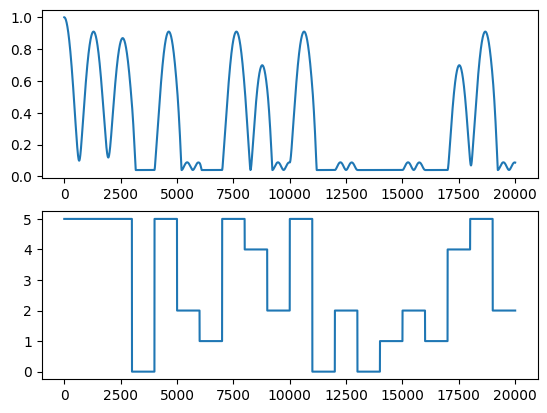

In [ ]:
steps = 20_000
dt = 0.001

system = BallMagSystem()
volt_data = DataGen.voltages_float(steps, 1000)
pos_data = BallMagSystem.valid_results(system, volt_data, dt)

plt.subplot(2, 1, 1)
plt.plot(pos_data)
plt.subplot(2, 1, 2)
plt.plot(volt_data)
plt.show()